In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [3]:
path_to_burned = 'Burned_Bathymetry.xlsx'
path_to_unburned = 'Unburned_Bathymetry.xlsx'

burned_excel = pd.read_excel(path_to_burned)
unburned_excel = pd.read_excel(path_to_unburned)

In [4]:
def get_bottom_dist(depth, df):
    return df.loc[depth.idxmax(), 'Distance (m)']


In [9]:
burned_excel_average = burned_excel[['Distance (m)', 'Depth (m)']].groupby(by='Distance (m)').mean().reset_index()
burned_excel_average['Transect'] = 'Average'
df_burned = pd.concat([burned_excel[['Transect', 'Distance (m)', 'Depth (m)']],burned_excel_average]).reset_index()
burned_bottom_dist = df_burned.groupby(by='Transect').agg({'Depth (m)': lambda x: get_bottom_dist(x, df_burned)}).reset_index().rename(columns={'Depth (m)': 'center_dist'})
df_burned = pd.merge(df_burned, burned_bottom_dist, how='left', on='Transect')
df_burned['dist_to_center'] = df_burned['center_dist'] - df_burned['Distance (m)']
df_burned['side'] = 'left'
df_burned.loc[df_burned['dist_to_center']<0, 'side'] = 'right'
df_burned.loc[df_burned['dist_to_center']==0, 'side'] = 'center'

unburned_excel_average = unburned_excel[['Distance (m)', 'Depth (m)']].groupby(by='Distance (m)').mean().reset_index()
unburned_excel_average['Transect'] = 'Average'
df_unburned = pd.concat([unburned_excel[['Transect', 'Distance (m)', 'Depth (m)']],unburned_excel_average]).reset_index()
unburned_bottom_dist = df_unburned.groupby(by='Transect').agg({'Depth (m)': lambda x: get_bottom_dist(x, df_unburned)}).reset_index().rename(columns={'Depth (m)': 'center_dist'})
df_unburned = pd.merge(df_unburned, unburned_bottom_dist, how='left', on='Transect')
df_unburned['dist_to_center'] = df_unburned['center_dist'] - df_unburned['Distance (m)']
df_unburned['side'] = 'left'
df_unburned.loc[df_unburned['dist_to_center']<0, 'side'] = 'right'
df_unburned.loc[df_unburned['dist_to_center']==0, 'side'] = 'center'



In [78]:
df_burned['Depth (m)'].max()

1.4

In [79]:
df_unburned['Depth (m)'].max()

1.7

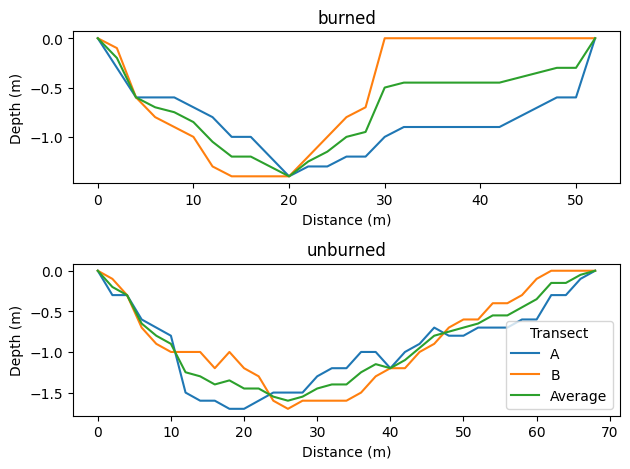

In [8]:
fig, axes = plt.subplots(2,1)
sns.lineplot(data=df_burned, x='Distance (m)', y=df_burned['Depth (m)']*-1, hue='Transect', ax=axes[0], legend=False)
sns.lineplot(data=df_unburned, x='Distance (m)', y=df_unburned['Depth (m)']*-1, hue='Transect', ax=axes[1])

axes[0].set_title('burned')
axes[1].set_title('unburned')

fig.tight_layout()

In [42]:
depth_range_burned = pd.DataFrame(columns = ['Depth (m)'], data=np.arange(0, df_burned['Depth (m)'].max(), 0.1))
depth_range_unburned = pd.DataFrame(columns = ['Depth (m)'], data=np.arange(0, df_unburned['Depth (m)'].max(), 0.1))

In [62]:
burned_diameters = []
for transect in df_burned['Transect'].unique():

    center_dist = df_burned['center_dist'].max()
    left_side = df_burned.loc[(df_burned['Transect']==transect) & (df_burned['side']=='left')]
    left_side = left_side.merge(depth_range_burned, on = 'Depth (m)', how='outer').sort_values(['Depth (m)','Distance (m)'])
    left_side['Transect'] = transect
    left_side['side'] = 'left'
    left_side['center_dist'] = center_dist
    left_side['Distance (m)'] = left_side['Distance (m)'].interpolate()

    right_side = df_burned.loc[(df_burned['Transect']==transect) & (df_burned['side']=='right')]
    right_side = right_side.merge(depth_range_burned, on = 'Depth (m)', how='outer').sort_values(['Depth (m)', 'Distance (m)'], ascending = [False, True])
    right_side['Transect'] = transect
    right_side['side'] = 'right'
    right_side['center_dist'] = center_dist
    right_side['Distance (m)'] = right_side['Distance (m)'].interpolate()

    center = df_burned.loc[df_burned['Distance (m)']==center_dist]
    burned_merged = left_side[['Distance (m)','Depth (m)']].merge(right_side[['Distance (m)','Depth (m)']], on = 'Depth (m)', suffixes=['_left', '_right'])
    burned_merged['diameter'] = burned_merged['Distance (m)_right'] - burned_merged['Distance (m)_left']
    burned_merged['transect'] = transect
    burned_merged['Depth (m)'] = burned_merged['Depth (m)'].round(1)
    burned_diameters.append(burned_merged)

burned_diameters = pd.concat(burned_diameters).reset_index().groupby(by=['transect', 'Depth (m)']).max().reset_index()

In [57]:
unburned_diameters = []
for transect in df_unburned['Transect'].unique():

    center_dist = df_unburned['center_dist'].max()
    left_side = df_unburned.loc[(df_unburned['Transect']==transect) & (df_unburned['side']=='left')]
    left_side = left_side.merge(depth_range_unburned, on = 'Depth (m)', how='outer').sort_values(['Depth (m)','Distance (m)'])
    left_side['Transect'] = transect
    left_side['side'] = 'left'
    left_side['center_dist'] = center_dist
    left_side['Distance (m)'] = left_side['Distance (m)'].interpolate()

    right_side = df_unburned.loc[(df_unburned['Transect']==transect) & (df_unburned['side']=='right')]
    right_side = right_side.merge(depth_range_unburned, on = 'Depth (m)', how='outer').sort_values(['Depth (m)', 'Distance (m)'], ascending = [False, True])
    right_side['Transect'] = transect
    right_side['side'] = 'right'
    right_side['center_dist'] = center_dist
    right_side['Distance (m)'] = right_side['Distance (m)'].interpolate()

    center = df_unburned.loc[df_unburned['Distance (m)']==center_dist]
    unburned_merged = left_side[['Distance (m)','Depth (m)']].merge(right_side[['Distance (m)','Depth (m)']], on = 'Depth (m)', suffixes=['_left', '_right'])
    unburned_merged['diameter'] = unburned_merged['Distance (m)_right'] - unburned_merged['Distance (m)_left']
    unburned_merged['transect'] = transect
    unburned_merged['Depth (m)'] = unburned_merged['Depth (m)'].round(1)

    unburned_diameters.append(unburned_merged)

unburned_diameters = pd.concat(unburned_diameters).reset_index().groupby(by=['transect', 'Depth (m)']).max().reset_index()

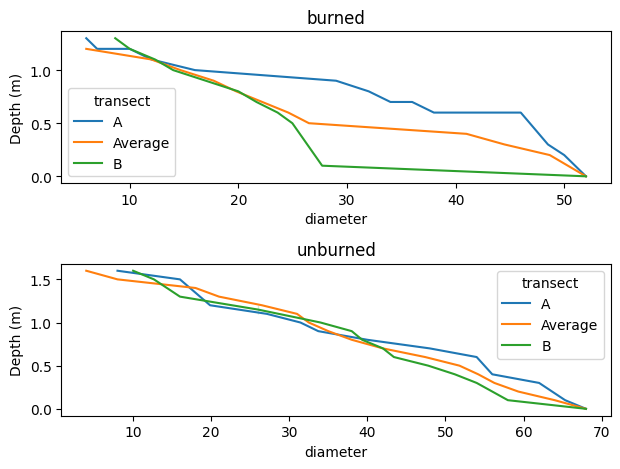

In [58]:
fig, axes = plt.subplots(2,1)
sns.lineplot(data = burned_diameters, x='diameter', y='Depth (m)', hue='transect', ax=axes[0])
sns.lineplot(data = unburned_diameters, x='diameter', y='Depth (m)', hue='transect', ax=axes[1])

axes[0].set_title('burned')
axes[1].set_title('unburned')

fig.tight_layout()

In [77]:
print('morphometry {}'.format(len(burned_diameters.loc[burned_diameters['transect']=='Average'])))
for i, row in burned_diameters.loc[burned_diameters['transect']=='Average'].iterrows():
    print('{} {}'.format(row['Depth (m)'], np.round((np.pi* (row['diameter']/2)**2))))

morphometry 14
0.0 2124.0
0.1 1990.0
0.2 1860.0
0.3 1555.0
0.4 1320.0
0.5 552.0
0.6 475.0
0.7 387.0
0.8 308.0
0.9 247.0
1.0 169.0
1.1 113.0
1.2 28.0
1.3 nan


In [76]:
print('morphometry {}'.format(len(unburned_diameters.loc[unburned_diameters['transect']=='Average'])))
for i, row in unburned_diameters.loc[unburned_diameters['transect']=='Average'].iterrows():
    print('{} {}'.format(row['Depth (m)'], np.round((np.pi* (row['diameter']/2)**2))))

morphometry 17
0.0 3632.0
0.1 3217.0
0.2 2765.0
0.3 2487.0
0.4 2307.0
0.5 2107.0
0.6 1765.0
0.7 1385.0
0.8 1134.0
0.9 962.0
1.0 830.0
1.1 755.0
1.2 552.0
1.3 346.0
1.4 254.0
1.5 50.0
1.6 13.0


In [65]:
unburned_diameters.loc[unburned_diameters['transect']=='Average']

,transect,Depth (m),index,Distance (m)_left,Distance (m)_right,diameter
17,Average,0.0,0,0.0,68.000000,68.000000
18,Average,0.1,1,1.0,65.000000,64.000000
19,Average,0.2,2,2.0,61.333333,59.333333
20,Average,0.3,3,4.4,60.666667,56.266667
21,Average,0.4,4,4.8,59.000000,54.200000
22,Average,0.5,5,5.2,57.000000,51.800000
23,Average,0.6,7,6.0,53.000000,47.400000
24,Average,0.7,8,7.0,49.000000,42.000000
25,Average,0.8,9,8.0,46.000000,38.000000
26,Average,0.9,10,10.0,45.000000,35.000000
